<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

<left><img width=25% src="img/cu_logo.svg"></left>

# Lecture 7: Dimensionality Reduction

__Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Announcements

# Agenda

### Part 1: What is Dimensionality Reduction?
- Definition and motivation
- Examples from motorcycles and Iris dataset

### Part 2: Principal Component Analysis
- PCA objectives: reconstruction and variance maximization
- Practical considerations

### Part 3: Non-linear Dimensionality Reduction
- When PCA fails on non-linear structures
- Multidimensional scaling (MDS) t-SNE

### Part 4: Interpretable Dimensionality Reduction
- PLIER: incorporating prior knowledge
- Applications to genetic studies

### Hands-on Exercise
- Apply dimensionality reduction techniques to real datasets

# Part 1: What is Dimensionality Reduction?

We will start by defining the task and providing some examples.

# Review: Unsupervised Learning

We have a dataset *without* labels. Our goal is to learn something interesting about the structure of the data:
* Clusters hidden in the dataset.
* Outliers: particularly unusual and/or interesting data points.
* Useful signal hidden in noise, e.g., human speech over a noisy phone.

# Dimensionality Reduction: Examples

Consider a dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ of motorcycles, characterized by a set of features.

* Features include size, color, maximum speed, etc.
* Suppose that two features are closely correlated: e.g., $x^{(i)}_j$ is the speed in `mph` and $x^{(i)}_k$ is the speed in `km/h`.
* The real dimensionality of the data is $d-1$!

We would like to automatically identify the correct data dimensionality.

Another example can be obtained from the Iris flower dataset.

In [1]:
# import standard machine learning libraries
import numpy as np
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()

Consider the sepal length and the sepal width of the flowers: they are closely correlated.

This suggests that we may reduce the dimensionality of the problem to one dimension: sepal size.

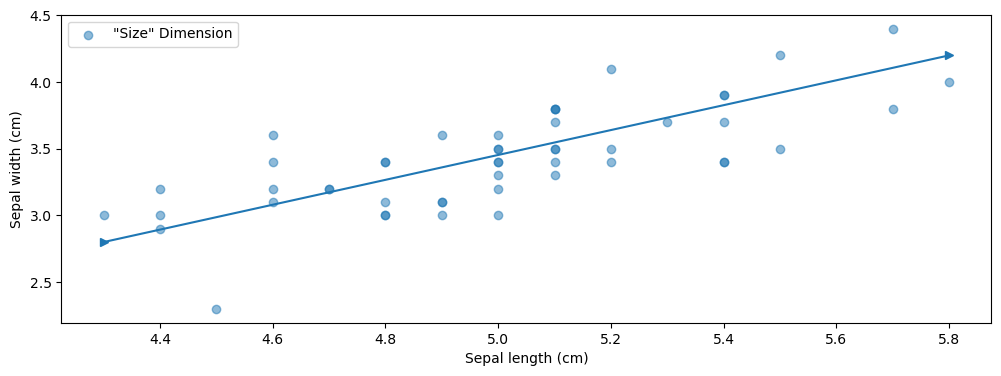

In [2]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [12, 4]

# Visualize the Iris flower dataset
setosa_flowers = iris.target == 0
plt.scatter(iris.data[setosa_flowers, 0], iris.data[setosa_flowers, 1], alpha=0.5)
plt.plot([4.3, 5.8], [2.8, 4.2], "->")
plt.ylabel("Sepal width (cm)")
plt.xlabel("Sepal length (cm)")
plt.legend(['"Size" Dimension']);

# Dimensionality Reduction

More generally, a dimensionality reduction algorithm learns from data an unsupervised model
$$f_\theta : \mathbb{R}^d \to \mathbb{R}^p,$$
where $\mathbb{R}^p$ contains low-dimensional representation of the data $(p<d)$.

For each input $x^{(i)}$, $f_\theta$ computes a low-dimensional representation $z^{(i)}$.

# Linear Dimensionality Reduction

The transformation
$$f_\theta : \mathbb{R}^d \to \mathbb{R}^p$$
is a linear function with parameters $\theta = W \in \mathbb{R}^{d \times p}$:
$$ z = f_\theta(x) = W^\top \cdot x. $$
The latent dimension $z$ is obtained from $x$ via a matrix $W$.

# Example: Discovering Structure in Digits

Dimensionality reduction can reveal interesting structure in digits without using labels.

<center><img width=40% src="img/aae_dim_reduc_2.png"></center>

# Example: DNA Analysis

Even linear dimensionality reduction is powerful. Here, it uncovers the geography of European countries from only DNA data

<center><img width=50% src="img/dna_map.jpg"></center>

# Other Kinds of Dimensionality Reduction

We will focus on a few dimensionality reduction techniques in this lecture, but there exist many other methods:
* Non-linear methods based on kernels (e.g., Kernel PCA)
* Non-linear methods based on deep learning (e.g., variational autoencoders)
* Non-linear methods based on maximizing signal independence (independent component analysis)
* Probabilistic versions of the above


See the `scikit-learn` guide, which covers [matrix factorization approaches](https://scikit-learn.org/stable/modules/decomposition.html) (like PCA) and [manifold learning](https://scikit-learn.org/stable/modules/manifold.html).

# Summary: Part 1

* **Dimensionality reduction:** Unsupervised learning of a mapping $f_\theta : \mathbb{R}^d \to \mathbb{R}^p$ where $p < d$
* **Linear dimensionality reduction:** Transformation $f_\theta(x) = W^\top x$ using matrix $W \in \mathbb{R}^{d \times p}$
* **Motivation:** Discover hidden structure, remove redundant features, reduce computational complexity
* **Real-world applications:** Revealing geographic structure from DNA data, discovering digit patterns, visualization
* **Types of methods:** Linear (PCA), kernel-based, deep learning (autoencoders), probabilistic approaches

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 2: Principal Component Analysis

We will now describe principal component analysis (PCA), one of the most widely used algorithms for dimensionality reduction.

# What Problem Does PCA Solve? Intuition.

In this example, the data lives in a lower-dimensional 2D plane within a 3D space (image [credit](https://doc.plob.org/machine_learning/14_Dimensionality_Reduction.html)).

<center><img width=50% src="img/pca_example_plane.png"></center>

PCA finds (1) this linear subspace and (2) the coordinates of the data in it.

# What Problem Does PCA Solve? Math.

Our first step is to make this goal more precise. Suppose we have datapoints $x \in \mathbb{R}^{d}$.

1. Finding a linear subspace means finding an (orthonormal) set of $p < d$ basis vectors
\begin{align}
W = [ w^{(1)}, w^{(2)}, \ldots, w^{(p)} ],
\end{align}
where $W \in \mathbb{R}^{d \times p}$ is the matrix of stacked vectors.

2. Finding projections of the data in the subspace means computing
\begin{align}
z =
\begin{bmatrix}
z_1 \\ z_2 \\ \vdots \\ z_k
\end{bmatrix}=
\begin{bmatrix}
(w^{(1)})^\top x \\ (w^{(2)})^\top x \\ \vdots \\ (w^{(k)})^\top x
\end{bmatrix}
= W^\top x
\end{align}

We can choose a basis $W$ for the data plane. The coordinates in this basis are denoted by $z$ (image [credit](https://doc.plob.org/machine_learning/14_Dimensionality_Reduction.html)).

<center><img width=80% src="img/pca_example.png"></center>

# Components of an Unsupervised Learning Algorithm

We will define PCA in terms of the three standard components of an ML algorithm.

$$ \underbrace{\text{Dataset}}_\text{Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Unsupervised Model} $$

The dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ does not include any labels.

# The PCA Model

The model for PCA is a function $f_\theta$ of the form
$$ z = f_\theta(x) = W^\top x, $$
where $\theta = W$ and $W$ is a $d \times p$ matrix of $p$ orthonormal column vectors denoted as $w^{(1)}, w^{(2)}, \ldots, w^{(p)}$.

Note that when $x = W z$, then $z = W^T x$ because $W^\top W = I$.

This model enables performing two tasks:
* __Encoding__: $z^{(i)} = W^\top x^{(i)}$, finding the low-dimensional form of $x$
\begin{align}
z^{(i)} =
\begin{bmatrix}
z^{(i)}_1 \\ z^{(i)}_2 \\ \vdots \\ z^{(i)}_k
\end{bmatrix}=
\begin{bmatrix}
(w^{(1)})^\top x^{(i)} \\ (w^{(2)})^\top x^{(i)} \\ \vdots \\ (w^{(k)})^\top x^{(i)}
\end{bmatrix}
= W^\top x^{(i)}
\end{align}

* __Decoding__: $\tilde x^{(i)} = W  z^{(i)}$, converting a low-dimensional $z^{(i)}$ to a high-dimensional reconstruction $\tilde x^{(i)}$ of $x^{(i)}$
$$ \tilde x^{(i)} = \sum_{k=1}^p w^{(k)} z_k^{(i)} = W z^{(i)} $$
Note that $\tilde x^{(i)}$ is the closest point in the subspace to $x^{(i)}$.

# PCA Objective: Reconstruction

How do we find a good subspace $\mathcal{Z}$ as defined by a set of orthonormal vectors $W$?

A natural objective is to minimize the reconstruction error
$$J_1(W) = \sum_{i=1}^n \| x^{(i)} - \tilde x^{(i)} \|_2^2 =\sum_{i=1}^n \| x^{(i)} - W W^\top x^{(i)} \|_2^2$$
between each input $x^{(i)}$ and its approximate reconstruction $$\tilde x^{(i)} = W \cdot z^{(i)} = W\cdot W^\top \cdot x^{(i)}.$$

# PCA Objective: Maximizing Variance

An alternative objective for learning a PCA model is maximizing variance.

We start with some intuition.

How do we automatically identify natural directions of variation in the data? Consider the following dataset (image by [Andrew Ng](http://cs229.stanford.edu/)).

<center><img width=45% src="img/pca_projection_data.png"></center>

One way to reduce the dimensionality of this dataset from is to project it along the following line.

<center><img width=50% src="img/pca_projection1.png"></center>

Projected data is tightly clustered around its mean. It has *low variance*.

An alternative projection is along the following line. Data is much more spread out: it has *high variance* around its mean.
<center><img width=50% src="img/pca_projection2.png"></center>
Our goal is to identify this direction automatically.

We may formalize this as follows.
* Let $\hat{\mathbb{E}}[f(x)]$ denote empirical expectation for any $f$:
$$\hat{\mathbb{E}}[f(x)] = \frac{1}{n}\sum_{i=1}^n f(x^{(i)}). $$

* Assume that we have centered the data, i.e.
$$\hat{\mathbb{E}}[x] = 0 \text{ and thus } \hat{\mathbb{E}}[W^\top x] = W^\top \hat{\mathbb{E}}[x] = 0.$$
<!-- $$\frac{1}{n}\sum_{i=1}^n x^{(i)} = 0 \text{ and thus } \frac{1}{n}\sum_{i=1}^n W^\top x^{(i)} = 0.$$ -->

* The variance of the projected data is
\begin{align*}
\hat{\mathbb{E}}\left[ \| z - \hat{\mathbb{E}}[z] \|^2 \right] =
\hat{\mathbb{E}}\left[ \| W^\top x - \hat{\mathbb{E}}[W^\top x] \|^2 \right]
& = \hat{\mathbb{E}}\left[ \| W^\top x \|^2 \right]
\end{align*}
<!-- \begin{align*}
\frac{1}{n} \sum_{i=1}^n \| W^\top x^{(i)} - \frac{1}{n}\sum_{i=1}^n x^{(i)} \|_2^2
& = \frac{1}{n} \sum_{i=1}^n \| W^\top x^{(i)}\|_2^2
\end{align*} -->

Thus, the variance objective is simply
$$J_2(W) = \hat{\mathbb{E}}\left[ \| W^\top x \|^2 \right] = \frac{1}{n} \sum_{i=1}^n \| W^\top x^{(i)}\|_2^2.$$

# Equivalence Between PCA Objectives

It turns out that minimizing reconstruction error and maximizing variance are equivalent.
$$\arg\min_W J_1(W) = \arg\max_W J_2(W).$$

This image by [Alex Williams](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/) provides intuition.

<center><img width=80% src="img/pca_two_views.png"></center>

Consider the operator $W W^\top x$. We can decompose any $x$ into a sum of two orthogonal vectors:
\begin{align*}
x
& = x + W W^\top x - W W^\top x \\
& = \underbrace{W W^\top x}_\text{projected data $\tilde x$ (D1)} + \underbrace{(I - W W^\top) x}_\text{difference between datapoint $x$ and $\tilde x$ (D2)}
\end{align*}

<center><img width=50% src="img/pca_decomposition.png"></center>

We can compute the norm of both sides to obtain
\begin{align*}
\|x\|_2^2
& = \| W W^\top x + (I - W W^\top) x \|_2^2 \\
& = \|W W^\top x\|_2^2 + \|(I - W W^\top) x\|_2^2 \\
& = \|W^\top x\|_2^2 + \|(I - W W^\top) x\|_2^2
\end{align*}
* In the second line, we used the fact that $W W^\top x$ and $(I - W W^\top) x$ are orthogonal (easy to check)
* In the third line, we used that $\|W a\| = \|a\|$ for any vector $a$ and orthogonal matrix $W$.

Thus we find that
\begin{align*}
J_1(W) & = \sum_{i=1}^n \|(I - W W^\top) x^{(i)}\|_2^2 \\
& = \sum_{i=1}^n \left( \|x^{(i)}\|_2^2 - \|W^\top x^{(i)}\|_2^2 \right) \\
&= - n\cdot J_2(W) + \text{const.}
\end{align*}
and minimizing the reconstruction objective $J_1$ is the same as maximizing the variance objective $J_2$.

# Finding Principal Components

Long story short, the principal components $W$ are found by:
* Eigendecomposition of the covariance matrix.
* Or performing singular value decomposition (SVD) on the input data.

# Algorithm: Principal Component Analysis

* __Type__: Unsupervised learning (dimensionality reduction)
* __Model family__: Linear projection $W^\top z$ of low-dimensional $z$
* __Objective function__: Reconstruction error or variance maximization
* __Optimizer__: Matrix eigendecomposition

# Practical Considerations

When applying PCA, the following tricks are useful.
* Before applying PCA, it is important to normalize the data to have zero mean and unit variance.
$$x_j^{(i)} \gets \frac{x_j^{(i)} - \mu_j}{\sigma_j} \text{for all $i,j$},$$
where $\mu_j, \sigma_j$ are the mean and variance along the $j$-th dimension.
* This addresses scaling issues due to units (`km/h` vs `cm/h`).
* In order to choose the optimal number of components, we can apply the Elbow method.

# An Example: Iris Flowers

Let's look at an example over the Iris flower dataset. In its entirety, it has four dimensions; let's visualize it in 3D by looking at the first 3 dimensions.

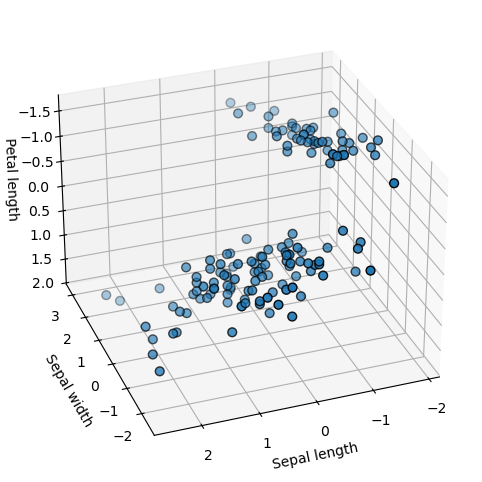

In [3]:
X, y = iris.data, iris.target
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# display data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("Sepal length")
ax.set_ylabel("Sepal width")
ax.set_zlabel("Petal length")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor="k", s=40)
ax.view_init(elev=-150.0, azim=110, roll=0)

We can implement PCA using a small number of `numpy` operations.

In [4]:
def pca_project(X, p=2):
    sigma = X.T.dot(X) / X.shape[0]  # form covariance matrix
    L, Q = np.linalg.eig(sigma)  # perform eigendecomposition
    W = Q[:, :p]  # get top p eigenvectors
    Z = X.dot(W)  # project on these eigenvectors
    return Z

Visualizing the data, we obtain the following structure.

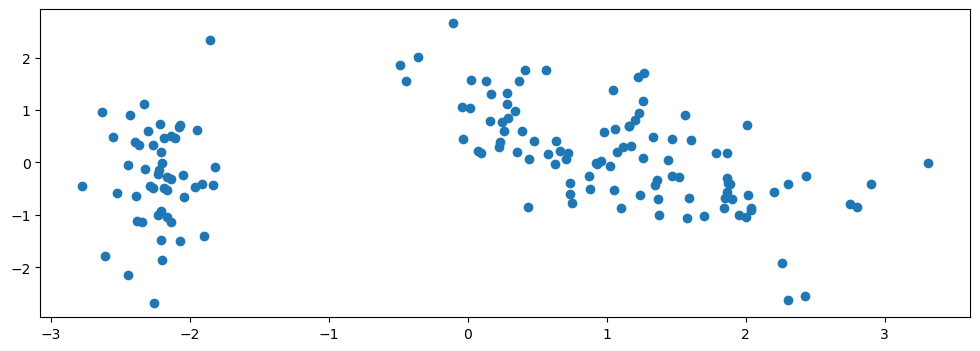

In [5]:
Z = pca_project(X, p=2)
plt.scatter(Z[:, 0], Z[:, 1]);

We can also add labels. The classes are well-separated.

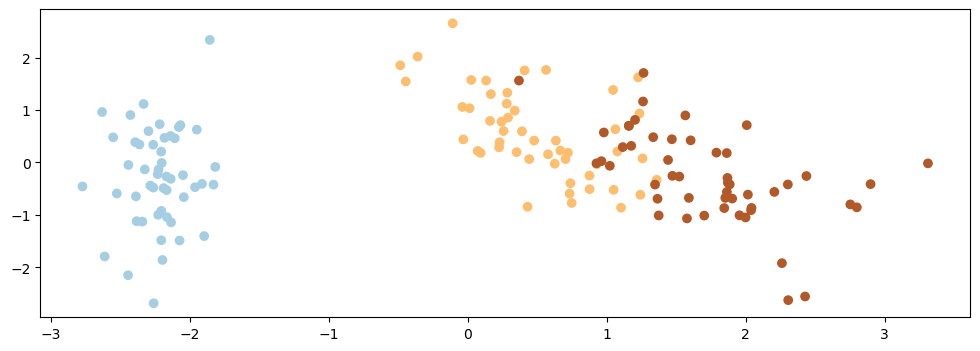

In [6]:
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap=plt.cm.Paired);

The separation is better than if we just chose the first two dimensions.

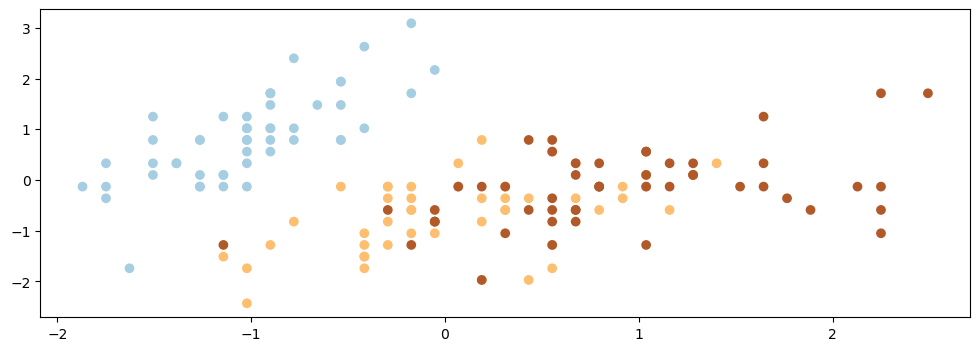

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired);

We can train two classifiers on this data and compare their accuracy.

PCA dimensions result in better accuracy than just choosing the first two dimensions.

In [8]:
from sklearn.linear_model import LogisticRegression

# train on non-PCA data
logreg1 = LogisticRegression(C=1e5)
logreg1.fit(X[:, :2], y)
print("Accuracy on first two dimensions: %.2f" % logreg1.score(X[:, :2], y))

# train on PCA data
logreg2 = LogisticRegression(C=1e5)
logreg2.fit(Z, y)
print("Accuracy on two PCA dimensions: %.2f" % logreg2.score(Z, y))

Accuracy on first two dimensions: 0.83
Accuracy on two PCA dimensions: 0.92


# Pros and Cons of PCA

PCA is perhaps the most widely used dimensionality reduction algorithm.
* It is both highly intuitive and effective
* It is also fast and easy to implement

Its limitations include:
* Linear projections may be too limited in some applications
* Choosing the right dimension $p$ can be somewhat of an art

# Summary: Part 2

* **PCA model:** Linear projection $z = W^\top x$ with orthonormal basis vectors $W \in \mathbb{R}^{d \times p}$
* **Two equivalent objectives:** Minimizing reconstruction error $\|x - WW^\top x\|^2$ or maximizing variance in projected space
* **Encoding and decoding:** Encode to low-dimensional $z = W^\top x$; decode to reconstruction $\tilde{x} = Wz$
* **Finding components:** Use eigendecomposition of covariance matrix or SVD of data matrix
* **Practical considerations:** Normalize data to zero mean and unit variance; use elbow method to choose number of components
* **Advantages:** Fast, interpretable, widely applicable; **Limitations:** Only captures linear relationships

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 3: Non-linear Dimensionality Reduction

We will now describe multidimensional scaling (MDS) and $t$-distributed stochastic neighbor embedding (TSNE), two non-linear dimensionality reduction techniques.

# When PCA fails

PCA is intuitive and easy to implement, but fails on non-linear structures

Let's consider this 2D S-curve. **What will the PCA look like?**

In [9]:
import numpy as np

np.set_printoptions(precision=2)
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 4]
from sklearn.datasets import make_s_curve


def make_s_curve_2d(n_samples=100, noise=0.0):
    np.random.seed(0)
    X, y = make_s_curve(n_samples=n_samples, noise=noise)
    X = X[:, [0, 2]]
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y


def fig_ax_with_padding():
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    ax = axs[1]
    axs[0].axis("off")
    axs[2].axis("off")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    return fig, axs[1]

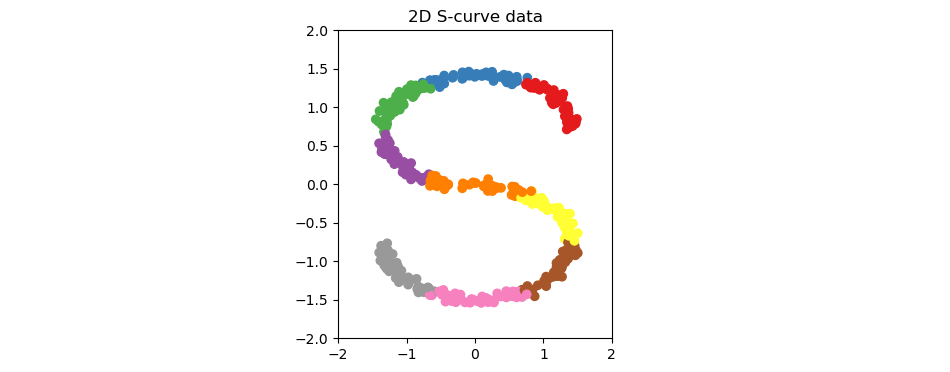

In [10]:
X, y = make_s_curve_2d(n_samples=500, noise=0.05)
fig, ax = fig_ax_with_padding()
ax.set_title("2D S-curve data")
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="Set1")

Running our PCA implementation on it gives:

In [11]:
def plot_pca_1d(X, Z, W):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap="Set1")
    axs[0].set_title("2D S-curve data")
    axs[0].set_xlabel("$x_0$")
    axs[0].set_ylabel("$x_1$")

    Z, W = pca_project(X, p=1)
    axs[1].scatter(Z, np.zeros_like(Z), c=y, cmap="Set1")
    axs[1].set_title("1D PCA projection")
    axs[1].set_xlabel("$z_0$")
    axs[1].set_yticks([])

    W_ortho = np.array([W[1, 0], -W[0, 0]])
    axs[0].arrow(
        0,
        0,
        W_ortho[0],
        W_ortho[1],
        head_width=0.2,
        head_length=0.2,
        fc="k",
        ec="k",
        lw=2,
    )
    axs[0].plot(
        [-5.0 * W[0, 0], 5.0 * W[0, 0]],
        [-5.0 * W[1, 0], 5.0 * W[1, 0]],
        "--",
        lw=2,
        color="k",
    )
    axs[0].set_xlim((-2.0, 2.0))
    axs[0].set_ylim((-2.0, 2.0))

    axs[0].set_aspect("equal")

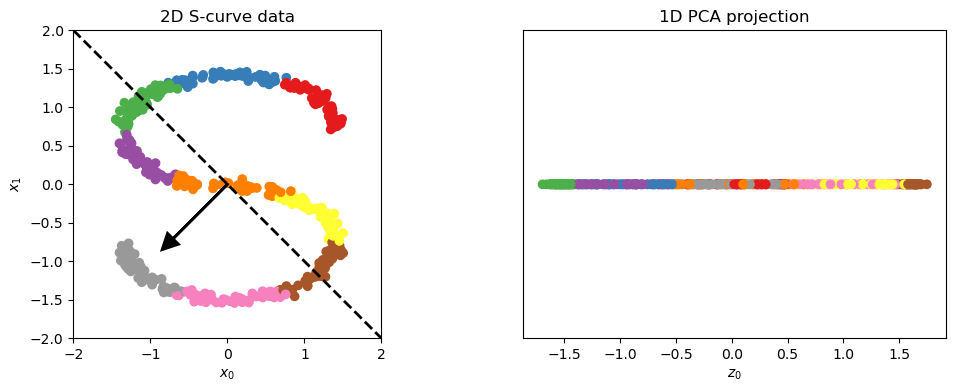

In [12]:
def pca_project(X, p=2):
    np.random.seed(0)
    Sigma = X.T.dot(X) / X.shape[0]  # form covariance matrix
    L, Q = np.linalg.eig(Sigma)  # perform eigendecomposition
    W = Q[:, :p]  # get top p eigenvectors
    Z = X.dot(W)  # project on these eigenvectors
    return np.real(Z), W  # return projected points and the projection matrix


Z, W = pca_project(X, p=2)
plot_pca_1d(X, Z, W)

In [13]:
from sklearn.manifold import MDS, TSNE


def visualize_pca_mds_tsne(
    X, y=None, p=2, tsne_perplexity=30, extra_plot_kwargs=None, ax_cb=None, legend=None
):
    assert p in [1, 2]
    nrow = 1
    ncol = 3 if p == 2 else 4
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 4, nrow * 4))

    plot_kwargs = {}
    if y is not None:
        plot_kwargs["c"] = y
        plot_kwargs["cmap"] = "Set1"
    if extra_plot_kwargs is not None:
        plot_kwargs.update(extra_plot_kwargs)

    if p == 1:
        axs[0].scatter(X[:, 0], X[:, 1], **plot_kwargs)
        axs[0].set_title("2D S-curve data")
        axs[0].set_xlabel("$x_0$")
        axs[0].set_ylabel("$x_1$")
        axs = axs[1:]

    X_centered = X - X.mean()
    Z, W = pca_project(X_centered, p=p)
    zeros = np.zeros_like(Z)
    p1 = axs[0].scatter(Z[:, 0], Z[:, 1] if p == 2 else zeros, **plot_kwargs)
    if y is not None and legend:
        handles, labels = p1.legend_elements()
        axs[0].legend(handles=handles, labels=legend)
    axs[0].set_title("PCA")
    axs[0].set_xlabel("$z_0$")
    axs[0].set_yticks([])
    if p == 2:
        axs[0].set_ylabel("$z_1$")
    if ax_cb is not None:
        ax_cb(Z, axs[0])

    np.random.seed(0)
    Z = MDS(n_components=p, normalized_stress="auto").fit_transform(X)
    axs[1].scatter(Z[:, 0], Z[:, 1] if p == 2 else zeros, **plot_kwargs)
    axs[1].set_title("MDS")
    axs[1].set_xlabel("$z_0$")
    axs[1].set_yticks([])
    if p == 2:
        axs[1].set_ylabel("$z_1$")
    if ax_cb is not None:
        ax_cb(Z, axs[1])

    np.random.seed(0)
    Z = TSNE(n_components=p, perplexity=tsne_perplexity).fit_transform(X)
    axs[2].scatter(Z[:, 0], Z[:, 1] if p == 2 else zeros, **plot_kwargs)
    axs[2].set_title("TSNE")
    axs[2].set_xlabel("$z_0$")
    axs[2].set_yticks([])
    if p == 2:
        axs[2].set_ylabel("$z_1$")
    if ax_cb is not None:
        ax_cb(Z, axs[2])

    return fig, axs

**So what happened?** PCA's linear projection fails on the non-linear structure

Now, we'll explore two non-linear visualization and embedding methods:
1. Multidimensional scaling (MDS)
2. $t$-distributed stochastic neighbor embedding (t-SNE)

(<Figure size 1600x400 with 4 Axes>,
 array([<Axes: title={'center': 'PCA'}, xlabel='$z_0$'>,
        <Axes: title={'center': 'MDS'}, xlabel='$z_0$'>,
        <Axes: title={'center': 'TSNE'}, xlabel='$z_0$'>], dtype=object))

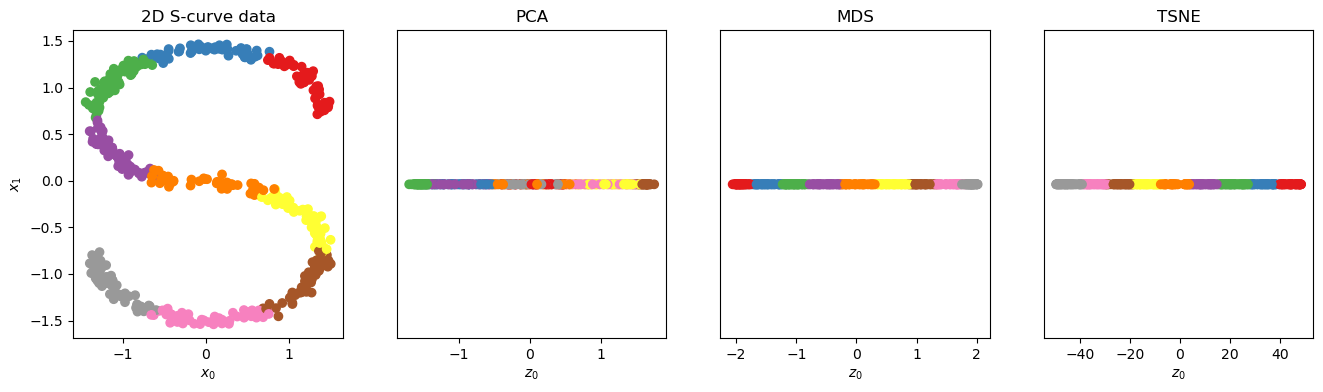

In [14]:
visualize_pca_mds_tsne(X, y, p=1)

# Part 3.1: Multidimensional scaling (MDS)

# Distinguishing projections and embeddings

PCA is based on **projections**
$$f_\theta(x)=W^\top x\in\mathbb{R}^d\ \text{where}\ \theta=W$$
+ PCA parameterizes a (linear) mapping of the data

This mapping gives **embeddings**, defined as $z^{(i)}=f_\theta\left(x^{(i)}\right)$
+ The embeddings are obtained by applying the mapping to every data point

# Embedding-based visualizations

In contrast to PCA, MDS and TSNE directly parameterize the **embeddings**
$$f_\theta\left(x^{(i)}\right)=z^{(i)}\in\mathbb{R}^d\ \text{where}\ \theta=\left\{z^{(i)}\right\}_{i=1}^n$$
+ Closely connected to the training dataset, cannot apply to new points
+ There is no explicit map or projection
+ Provides much more flexibility, points can be placed anywhere

# Reconstructing pairwise distances

Consider a pair of points $x^{(i)}$ and $x^{(j)}$. Ideally, we want the distance of
the corresponding embeddings to match their distance:
$$\|x^{(i)}-x^{(j)}\| \approx \|z^{(i)}-z^{(j)}\|$$

Since the embeddings are in a lower-dimensional space, the distances won't be perfectly matched.

But, they'll get close and hopefully give us a good visualization.

# The stress loss function

We define the **stress** loss function on every pair of points as
$$J_{\rm stress}(\theta)=\sum_{i\neq j} (\|x^{(i)}-x^{(j)}\| - \|z^{(i)}-z^{(j)}\|)^2$$

# Optimizing MDS

There is no closed-form solution to optimizing the stress of the embeddings.

MDS optimization is usually done with an algorithm called SMACOF.

# Using MDS from `scikit-learn`

Let's run MDS from `scikit-learn` on the S-curve data:

In [15]:
def euclidean_distances(X):
    return np.sqrt(np.sum((X[:, None] - X[None]) ** 2, axis=-1))


def stress_fn(Z, D):
    Z_dists = euclidean_distances(Z)
    val = np.sum((D - Z_dists) ** 2) / 2.0
    return val


def visualize_our_mds(X, y):
    nrow = 1
    ncol = 3
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 4, nrow * 4))

    axs[0].scatter(X[:, 0], X[:, 1], c=y, cmap="Set1")
    axs[0].set_title("2D S-curve data")
    axs[0].set_xlabel("$x_0$")
    axs[0].set_ylabel("$x_1$")
    axs = axs[1:]

    Z, W = pca_project(X, p=1)
    zeros = np.zeros_like(Z)
    axs[0].scatter(Z[:, 0], zeros, c=y, cmap="Set1")
    D = euclidean_distances(X)
    stress = stress_fn(Z, D)
    axs[0].set_title(f"PCA (stress={stress:.2e})")
    axs[0].set_xlabel("$z_0$")
    axs[0].set_yticks([])

    np.random.seed(0)
    Z_scipy = MDS(n_components=1, normalized_stress="auto").fit_transform(X)
    axs[1].scatter(Z_scipy[:, 0], zeros, c=y, cmap="Set1")
    stress = stress_fn(Z_scipy, D)
    axs[1].set_title(f"sklearn's MDS (stress={stress:.2e})")
    axs[1].set_xlabel("$z_0$")
    axs[1].set_yticks([])
    return Z_scipy

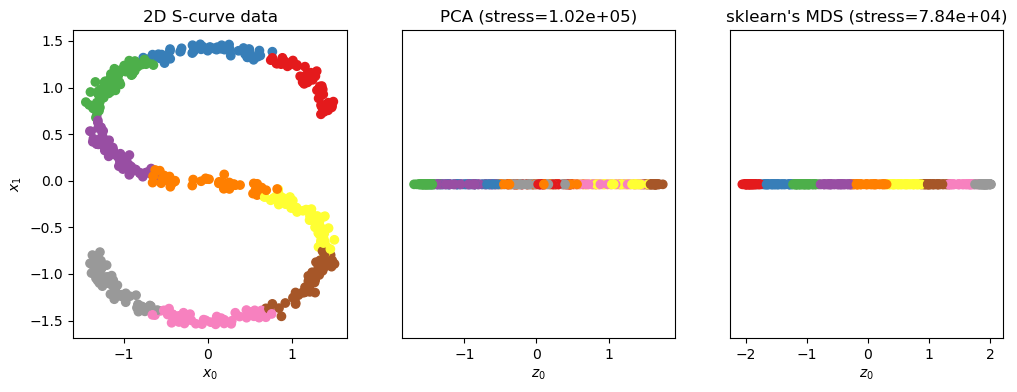

In [16]:
Z_sklearn = visualize_our_mds(X, y)

```python
from sklearn.manifold import MDS
Z = MDS(n_components=1, normalized_stress="auto").fit_transform(X)
```

It's also useful to look at the distance matrices.
This shows the difficulty of reproducing the full fidelity of the original distances.

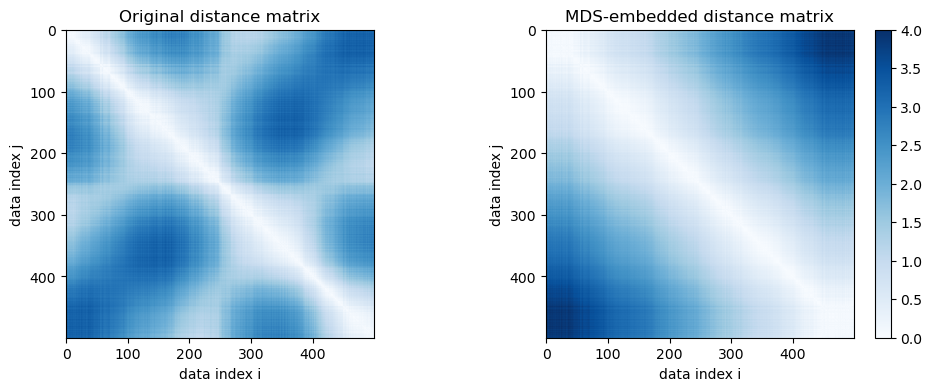

In [17]:
I = np.argsort(y)
y = y[I]
X = X[I]
Z = Z[I]
Z_sklearn = Z_sklearn[I]  # sort by location

D_original = euclidean_distances(X)
D_embedded = euclidean_distances(Z_sklearn)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(D_original, cmap="Blues", vmin=0.0, vmax=4.0)
img = axs[1].imshow(D_embedded, cmap="Blues", vmin=0.0, vmax=4.0)
axs[0].set_title("Original distance matrix")
axs[1].set_title("MDS-embedded distance matrix")
fig.colorbar(img, cmap="Blues")
for ax in axs:
    ax.set_xlabel("data index i")
    ax.set_ylabel("data index j")

# Algorithm: Multidimensional scaling (MDS)

* __Type__: Unsupervised learning (dimensionality reduction)
* __Model family__: Embeddings ($f_\theta(x^{(i)})=z^{(i)}$)
* __Objective function__: Stress $J_{\rm stress}(\theta)=\sum_{i\neq j} (\|x^{(i)}-x^{(j)}\| - \|z^{(i)}-z^{(j)}\|)^2$
* __Optimizer__: Iterative (ideally SMACOF)

---

The MDS variant we have covered is called "*metric MDS*", and there are others.

# Part 3.2: $t$-distributed stochastic neighbor embedding ($t$-SNE)

<center>
~62k citations (Dec 2025) <br/>
<img width='70%' src="img/tsne-paper.png"/>
</center>

# Difficulties of reproducing pairwise distances

Reproducing all of the pairwise distances in a lower-dimensional space is hard,
even when we have full control over the embedding locations.

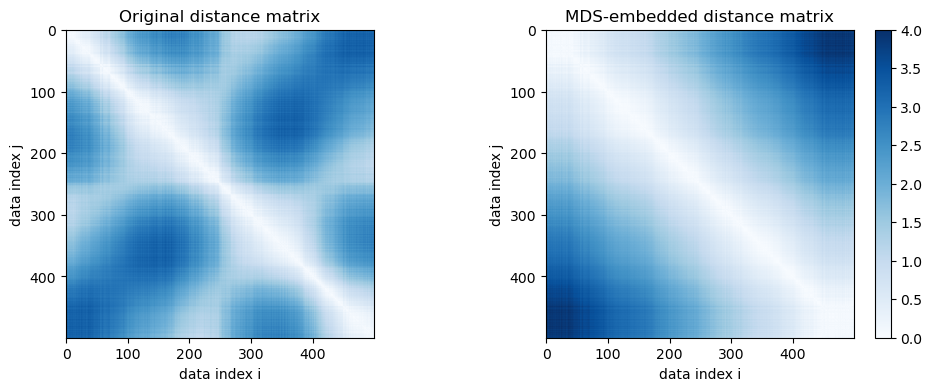

In [18]:
fig  # display the MDS distances from before

# How to improve poor pairwise distance reconstructions?

1. If we just care about reproducing the distances and not visualization, we could make the dimension of the embedding space larger
2. If we want to stay in a low-dimensional space, we can change the notion of distance (this is what TSNE does)

# Probabilistic (stochastic) pairwise distances

Given a point $x^{(i)}$, measure the "distance" to another point by the probability the distance to that point was sampled from a Gaussian, and normalize it.

Formally for $j\neq i$, this is $p_{j|i}\propto \exp\{-\|x^{(i)}-x^{(j)}\|^2/2\sigma_i^2\}$
normalized so that $\sum_j p_{j|i} = 1$.
Then, the probabilities are symmetrized as $p_{ij} \propto p_{j|i} + p_{i|j}$.

<center>
<img width='60%' src='img/tsne.jpeg'/> <br/>
<small><span style='color: grey'>Image source: https://spotintelligence.com/2023/12/22/practical-guide-t-sne/</span></small>
</center>

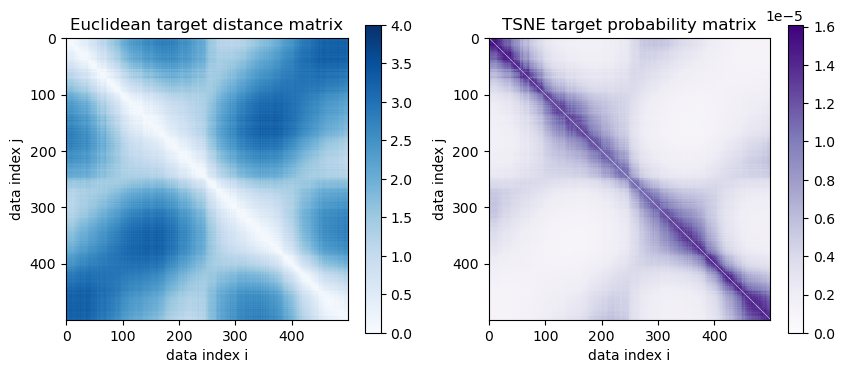

In [19]:
def gaussian_distances(X, bandwidth):
    return np.exp(-euclidean_distances(X) / (2.0 * bandwidth))


def get_tsne_target_probability(X, bandwidth=0.6):
    D = gaussian_distances(
        X, bandwidth=bandwidth
    )  # in the full TSNE, the bandwidth searched over for each i.
    p_j_given_i = D / (
        D.sum(axis=1) - 1.0
    )  # normalize the distances so \sum_j p_{j|i}=1 for every i.
    np.fill_diagonal(p_j_given_i, 0.0)  # p_{i|i} = 0 for every i.
    p_ij = (p_j_given_i + p_j_given_i.T) / (
        2.0 * X.shape[0]
    )  # symmetrize and normalize so \sum_{i,j} p_{i,j} = 1.
    return p_ij


p_ij = get_tsne_target_probability(X)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
img = axs[0].imshow(D_original, cmap="Blues", vmin=0.0, vmax=4.0)
fig.colorbar(img)
img = axs[1].imshow(p_ij, cmap="Purples")
fig.colorbar(img)
axs[0].set_title("Euclidean target distance matrix")
axs[1].set_title("TSNE target probability matrix")
for ax in axs:
    ax.set_xlabel("data index i")
    ax.set_ylabel("data index j")

In [20]:
print(f"sum_ij p_ij: {p_ij.sum():.2f}")

sum_ij p_ij: 1.00


We can look at our MDS solution under this new probabilistic similarity:

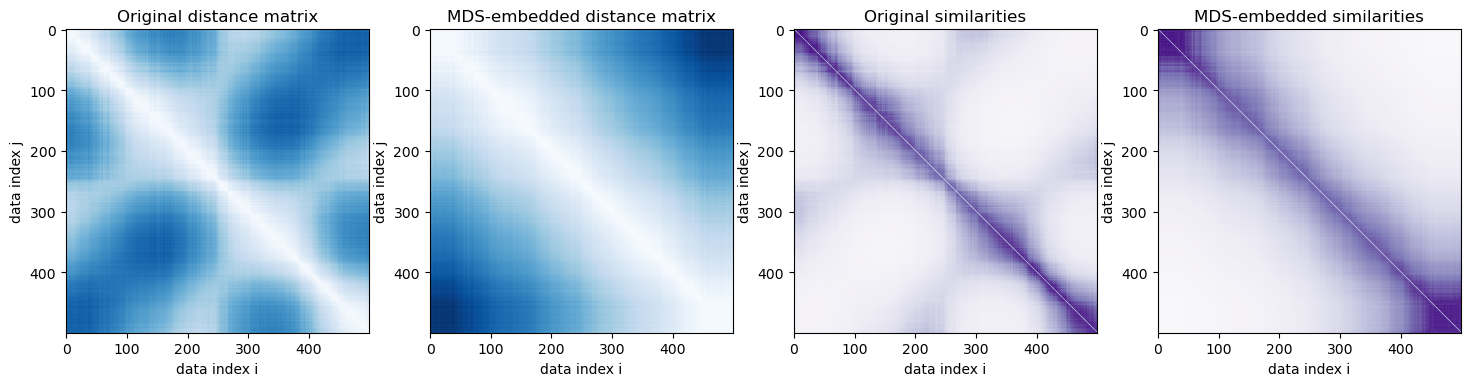

In [21]:
p_ij_embedded = get_tsne_target_probability(Z_sklearn)
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
axs[0].imshow(D_original, cmap="Blues", vmin=0.0, vmax=4.0)
axs[1].imshow(D_embedded, cmap="Blues", vmin=0.0, vmax=4.0)
axs[2].imshow(p_ij, cmap="Purples")
axs[3].imshow(p_ij_embedded, cmap="Purples")
axs[0].set_title("Original distance matrix")
axs[1].set_title("MDS-embedded distance matrix")
axs[2].set_title("Original similarities")
axs[3].set_title("MDS-embedded similarities")
for ax in axs:
    ax.set_xlabel("data index i")
    ax.set_ylabel("data index j")

# The TSNE loss: the Kullback-Leibler

Let's call $P_X$ the similarity matrix of the true data and $Q_\theta$ the similarity matrix of the embeddings.
Since these are valid probability distributions, we can define the loss to be the distance between them.
TSNE does this with the Kullback-Leibler divergence:

$$J_{\rm TSNE}={\rm KL}(P_X||Q_\theta):=\sum_{i\neq j} p_{ij}\log\frac{p_{ij}}{q_{ij}}$$

<center>
<img width='60%' src='img/kl.jpg'/> <br/>
<small><span style='color: grey'>Image source: https://blog.evjang.com/2016/08/variational-bayes.html</span></small>
</center>

# TSNE's perplexity parameter

In creating $p_{j|i}\propto \exp\{-\|x^{(i)}-x^{(j)}\|^2/2\sigma_i^2\}$, there is the choice of what bandwidth $\sigma_i$ to use.

TSNE advocates to adaptively set the bandwidth different for every $i$ so every $p_{j|i}$ has the same **entropy** and **perplexity**.

The **entropy** of a categorical distribution is defined by $H(p)=-\sum_j p_j \log p_j$, and the **perplexity** is defined by ${\rm Perp}(p) = 2^{H(p)}$

We can think of the perplexity parameter as controlling how spread out the mass of the reference distribution is &mdash; how many *neighbors* are used. One way to see this is just to ablate across constant bandwidths.

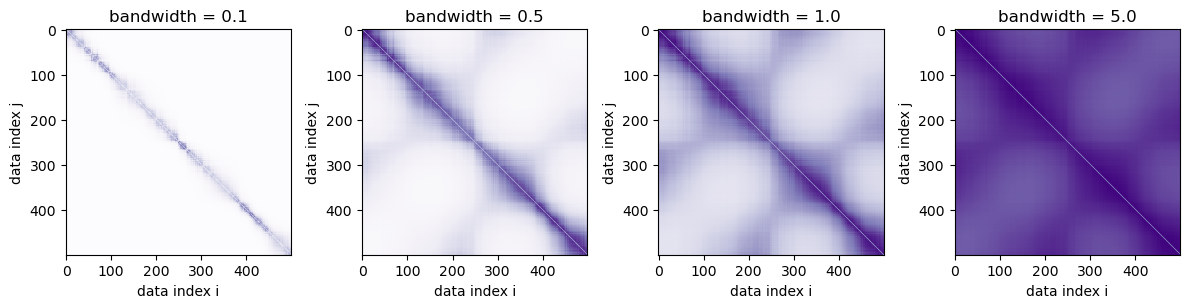

In [22]:
bandwidths = [0.1, 0.5, 1.0, 5.0]

fig, axs = plt.subplots(1, len(bandwidths), figsize=(12, 4))
for ax, bandwidth in zip(axs, bandwidths):
    ax.set_xlabel("data index i")
    ax.set_ylabel("data index j")
    p = get_tsne_target_probability(X, bandwidth=bandwidth)
    ax.imshow(p, cmap="Purples")
    ax.set_title(f"bandwidth = {bandwidth:.1f}")
fig.tight_layout()

# Algorithm: TSNE

* __Type__: Unsupervised learning (dimensionality reduction)
* __Model family__: Embeddings ($f_\theta(x^{(i)})=z^{(i)}$)
* __Objective function__: KL between probabilistic similarities, $J_{\rm TSNE}={\rm KL}(P_X || Q_\theta)$
* __Optimizer__: Gradient descent

# Summary: Part 3

* **Embedding-based methods:** MDS and t-SNE directly parameterize embeddings $z^{(i)}$ rather than learning a projection function
* **MDS (Multidimensional Scaling):** Preserves pairwise distances by minimizing stress $\sum_{i\neq j} (\|x^{(i)}-x^{(j)}\| - \|z^{(i)}-z^{(j)}\|)^2$
* **t-SNE:** Uses probabilistic pairwise similarities instead of Euclidean distances; better for non-linear structures
* **KL divergence loss:** t-SNE minimizes ${\rm KL}(P_X || Q_\theta)$ between original and embedded similarity distributions
* **Perplexity parameter:** Controls effective number of neighbors; adaptively sets bandwidth for each point
* **When to use:** Non-linear methods excel when data lies on curved manifolds where PCA fails

<left><img width=25% src="img/cu_logo.svg"></left>
# Part 4: Interpretable Dimensionality Reduction

We will now describe methods that incorporate prior knowledge to derive an interpretable low-dimensional space.

# Pathway-level information extractor (PLIER)

<left><img width=80% src="img/plier_article.png"></left>

# PLIER: Overview

<left><img width=75% src="img/plier.png"></left>

# PLIER loss
Given matrix $\mathbf{Y}$ (input gene expression data) and the prior knowledge matrix $\mathbf{C}$, PLIER finds matrices $\mathbf{Z}$, $\mathbf{B}$ and $\mathbf{U}$ minimizing

$$J_{\rm PLIER}=\underbrace{||\mathbf{Y} - \mathbf{Z}\mathbf{B}||^{2}_{F}}_\text{Reconstruction error} + \lambda_1 \underbrace{||\mathbf{Z} - \mathbf{C}\mathbf{U}||^{2}_{F}}_\text{Prior knowledge} + \lambda_2 \underbrace{||\mathbf{B}||^{2}_{F}}_\text{$L^2$ regularization} + \lambda_3 \underbrace{||\mathbf{U}||_{L^1}}_\text{$L^1$ regularization}$$

# PLIER + genetic studies on complex human traits

<left><img width=80% src="img/phenoplier.png"></left>

$\mathbf{Z}^{(i)}$ in PLIER can be understood as a gene co-expression network or gene module.

<left><img width=70% src="img/omnigenic_phenoplier.png"></left>

# PLIER + genetic studies on complex human traits
<left><img width=100% src="img/phenoplier_overview1.png"></left>

# PLIER + genetic studies on complex human traits
<left><img width=100% src="img/phenoplier_overview2.png"></left>

# PLIER + genetic studies on complex human traits
<left><img width=100% src="img/phenoplier_overview3.png"></left>

# Algorithm: PLIER

* __Type__: Unsupervised learning (dimensionality reduction)
* __Model family__: Linear projection $W^\top z$ of low-dimensional $z$ with nonnegativity constraint
* __Objective function__: Reconstruction error and prior knowledge alignment
* __Optimizer__: Block coordinate minimization

# Summary: Part 4

* **PLIER (Pathway-Level Information ExtractoR):** Incorporates prior biological knowledge (pathways) into dimensionality reduction
* **Interpretable latent variables:** Each dimension $\mathbf{Z}^{(i)}$ corresponds to gene co-expression modules aligned with known pathways
* **Multi-objective loss:** Balances reconstruction error, prior knowledge alignment (via matrix $\mathbf{C}$), and sparsity (L1/L2 regularization)
* **Application to genetics:** Gene modules from PLIER can be combined with GWAS to identify disease-relevant pathways
* **Advantages:** Produces biologically interpretable dimensions; integrates domain knowledge; enables mechanistic insights

# **Hands-on**: Applying dimensionality reduction techniques

* Open file `lecture09-hands_on-solved.ipynb` and follow the instructions there.

# Anonymous Feedback On This Lecture

<center>
    <img width=60% src="img/feedback_form_qr.png">
</center>

* **Link:** https://forms.office.com/r/prXY35CNuz
* **Lecture number:** 7
* **Lecture topic:** dimensionality reduction